In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread
import os
import time
import datetime
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.manifold import TSNE

### Build dataloader

Randomly pick patches!

In [3]:
class MyoDataSet(Dataset):
    def __init__(self, folder, mode, len_in, normalization=1000, crop_size = None):     # Images are placed under a single folder; first image name is treatment type
        super().__init__()

        if mode=='Train':
            fpath = folder+'/Train'
        elif mode=='Test':
            fpath = folder+'/Test'
        else:
            raise ValueError('Folder needs to named Train or Test!')
        
        fileList = os.listdir(fpath)       # find all images in folder
        self.image_stacks = []
        self.image_size = []
        self.label_list = []
        for ii in range(len(fileList)):
            if fileList[ii][-4:-1] == ".ti":  ## Proceed only if it's a tif
                print(fileList[ii])
                file = fpath+'/'+fileList[ii]
                im = imread(file).astype('float32')
                
                # Create patches if crop_size is specified
                if crop_size is not None:
                    T, H, W = im.shape
                    stride = int(crop_size / 2)
                    
                    # Generate patches
                    patches = []
                    # Check if image is larger than crop_size
                    if H >= crop_size and W >= crop_size:
                        h_starts = range(0, H - crop_size + 1, stride)
                        w_starts = range(0, W - crop_size + 1, stride)
                        for h_s in h_starts:
                            for w_s in w_starts:
                                patches.append(im[:, h_s:h_s+crop_size, w_s:w_s+crop_size])
                    else:
                        # Fallback if image is smaller than crop_size
                        patches.append(im[:, 0:crop_size, 0:crop_size])
                        
                    # Process each patch
                    for patch in patches:
                        if (np.max(patch) - np.min(patch)) < 1e-6:
                            self.image_stacks += [torch.Tensor(np.zeros(patch.shape))]
                        else:
                            self.image_stacks += [torch.Tensor((patch - np.min(patch)) / (np.max(patch) - np.min(patch)))]
                        
                        self.image_size += [patch.shape[0]]
                        self.label_list += [fileList[ii].split('_')[0]+fileList[ii].split('_')[2][-5]]
                else:
                    # No cropping
                    if (np.max(im) - np.min(im)) < 1e-6:
                        self.image_stacks += [torch.Tensor(np.zeros(im.shape))]
                    else:
                        self.image_stacks += [torch.Tensor((im - np.min(im)) / (np.max(im) - np.min(im)))]

                    self.image_size += [im.shape[0]]
                    self.label_list += [fileList[ii].split('_')[0]+fileList[ii].split('_')[2][-5]]
        
        self.len_in = len_in
        
    def __len__(self):
        numMovie = len(self.label_list)
        return np.sum(self.image_size) - numMovie * (self.len_in -1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        eff_img_size = np.array(self.image_size) - (self.len_in - 1)
        cum_img_size = np.cumsum(eff_img_size)
        image_id = np.sum(idx>=cum_img_size)
        stack_id = idx if image_id==0 else idx-cum_img_size[image_id-1]

        image_stack = self.image_stacks[image_id]
        x = {'input': image_stack[stack_id:stack_id+self.len_in], 'target': image_stack[stack_id:stack_id+self.len_in], 'label': self.label_list[image_id]}

        return x
    
    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader

In [4]:
#im1 = imread('./data/Train/JLY_cell1_cutout1.tif').astype('float32')
trainSet = MyoDataSet('./data/', 'Train', 6, crop_size = 32)
#testSet = MyoDataSet('./data', 'Test', 1)
print('There are', len(trainSet), 'images in the training set.')# and', len(testSet), 'images in the test set.')

JLY_cell1_cutout2.tif
JLY_cell1_cutout1.tif
WT_cell1_cutout1.tif
WT_cell1_cutout2.tif
There are 8722 images in the training set.


tensor(0.7623)
tensor(0.9178)
tensor(0.7867)
tensor(0.4398)
tensor(0.3389)


<Figure size 600x800 with 0 Axes>

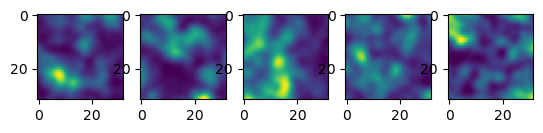

In [6]:
ct = 0
plt.figure(figsize=(6,8))
fig, ax = plt.subplots(1, 5)
for id in np.random.randint(len(trainSet), size = 5):
    x = trainSet[id]
    print(x['input'].max())
    ax[ct].imshow(x['input'][0, ...].squeeze())
    ct += 1

In [9]:
print(trainSet[4]['label'])

JLY2


In [7]:
train_loader = trainSet.get_loader(np.arange(len(trainSet)), 32, 0)
x = next(iter(train_loader))
print(x['target'][0,:].max())
#for thisbatch in train_loader:
#    print(thisbatch['input'].shape)
print(len(train_loader))

tensor(0.4952)
273


In [26]:
x['input'].shape

torch.Size([10, 6, 128, 128])

### Define convolutional autoencoder

In [8]:
class encoderNN(nn.Module):
    def __init__(self, input_size=(1, 128, 128), fmaps=[2, 4, 8], downsample_factor=2, neck_dim=100):
        super().__init__()

        in_channel, h, w = tuple(input_size)
        current_size = (h, w)

        # List of encoder layers
        encoderList = []
        current_fmaps = in_channel
        # Apply MaxPool to all but the last fmap
        for out_fmap in fmaps[:-1]:
            encoderList += [nn.Conv2d(current_fmaps, out_fmap, kernel_size=(3,3), padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(out_fmap),
                            nn.MaxPool2d((downsample_factor, downsample_factor))]
            current_fmaps = out_fmap
            h = int(h/downsample_factor)
            w = int(w/downsample_factor)
        
        # Final convolution with last fmap (no MaxPool)
        self.encoder = nn.Sequential(*encoderList, nn.Conv2d(current_fmaps, fmaps[-1], kernel_size=(3,3), padding=1), nn.ReLU(), nn.BatchNorm2d(fmaps[-1]))
        self.bottom_h = h
        self.bottom_w = w

        # List of bottleneck layers
        dense1 = fmaps[-1]*h*w
        neckList = [nn.Flatten(),
                    nn.Linear(dense1, neck_dim),
                    nn.ReLU(),
                    nn.Dropout()]
                    #nn.Linear(neck_dim, 20),
                    #nn.ReLU(),
                    #nn.Dropout()]

        self.bottleneck = nn.Sequential(*neckList)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        return x

class interp(nn.Module):
    def __init__(self, size, mode='nearest-exact'):
        super().__init__()

        self.size = size
        self.mode = mode

    def forward(self, x):
        return nn.functional.interpolate(x, size = self.size, mode = self.mode)

class decoderNN(nn.Module):
    def __init__(self, output_size=(1, 128, 128), fmaps=[2, 4, 8], upsample_factor=2, neck_dim=100):
        super().__init__()

        target_fmaps, h, w = tuple(output_size)
        layers = len(fmaps) - 1  # Number of MaxPool/ConvTranspose2d steps
        self.bottom_h = int(h * upsample_factor**(-layers))
        self.bottom_w = int(w * upsample_factor**(-layers))
        self.in_channel = fmaps[-1]  # Last feature map count

        dense1 = self.in_channel * self.bottom_h * self.bottom_w

        self.upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

        decoderList = []
        current_fmaps = self.in_channel    

        # First mirror the last encoder conv layer
        fmaps = [target_fmaps] + fmaps  # Add target_fmaps at the beginning   
        decoderList += [nn.Conv2d(current_fmaps, fmaps[-2], kernel_size=(3,3), padding=1),
                        nn.BatchNorm2d(fmaps[-2]),
                        nn.ReLU()]
        current_fmaps = fmaps[-2]

        # Reverse the feature map list for decoding (exclude the last one since we start from it)
        reversed_fmaps = list(reversed(fmaps[:-2]))
        for out_fmaps in reversed_fmaps:
            decoderList += [nn.ConvTranspose2d(current_fmaps, current_fmaps, kernel_size = (3,3), stride = upsample_factor, padding = 1, output_padding = 1),
                            nn.Conv2d(current_fmaps, out_fmaps, kernel_size=(3,3), padding=1),
                            nn.BatchNorm2d(out_fmaps),
                            nn.ReLU()] #interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, out_fmaps, kernel_size=(3,3), padding=1),
            current_fmaps = out_fmaps
                        
        self.decoder = nn.Sequential(*decoderList)

    def forward(self, x):
        x = self.upNeck(x)
        x = x.view(-1, self.in_channel, self.bottom_h, self.bottom_w)
        x = self.decoder(x)
        return x


class CAE(nn.Module):
    def __init__(self, input_size = (1, 128, 128), output_size = (1, 128, 128), fmaps = [2, 4, 8], sample_factor = 2, neckdim = 100):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fmaps = fmaps
        self.sample_factor = sample_factor
        self.neckdim = neckdim

        self.encoding = encoderNN(self.input_size, self.fmaps, self.sample_factor, self.neckdim)
        self.decoding = decoderNN(self.output_size, self.fmaps, self.sample_factor, self.neckdim)
        
    def forward(self, x):
        encoded = self.encoding(x)
        decoded = self.decoding(encoded)
        return decoded

In [9]:
# Print model summary
input_size = (6, 32, 32)
output_size = (1, 32, 32)
fmaps = [36, 216, 432]
sample_factor = 2
neckdim = 1000
model = CAE(input_size, output_size, fmaps, sample_factor, neckdim)
summary(model, input_size=(10, 6, 32, 32))       # Input size for torchinfo needs to have the size (B,C,H,W)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [10, 1, 32, 32]           --
├─encoderNN: 1-1                         [10, 1000]                --
│    └─Sequential: 2-1                   [10, 432, 8, 8]           --
│    │    └─Conv2d: 3-1                  [10, 36, 32, 32]          1,980
│    │    └─ReLU: 3-2                    [10, 36, 32, 32]          --
│    │    └─BatchNorm2d: 3-3             [10, 36, 32, 32]          72
│    │    └─MaxPool2d: 3-4               [10, 36, 16, 16]          --
│    │    └─Conv2d: 3-5                  [10, 216, 16, 16]         70,200
│    │    └─ReLU: 3-6                    [10, 216, 16, 16]         --
│    │    └─BatchNorm2d: 3-7             [10, 216, 16, 16]         432
│    │    └─MaxPool2d: 3-8               [10, 216, 8, 8]           --
│    │    └─Conv2d: 3-9                  [10, 432, 8, 8]           840,240
│    │    └─ReLU: 3-10                   [10, 432, 8, 8]           --
│ 

### Define model training/validation

In [11]:
if not os.path.exists('./logs'):
    os.mkdir('./logs')
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 5162), started 1 day, 22:46:25 ago. (Use '!kill 5162' to kill it.)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
## To do: move to device, metric for validation? training rate scheduler?

def train(model, dataloader, lossfn, optimizer, epochNum, tb_logger, device=None):     # Training step for each epoch
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for minibatch in dataloader:
        y = model(minibatch['input'].to(device))
        loss = lossfn(y, minibatch['target'].to(device))
        loss.backward()
        optimizer.step()
        totalLoss += loss

    if tb_logger is not None:
        tb_logger.add_scalar(tag="train_loss", scalar_value=totalLoss.item(), global_step=epochNum)

    return totalLoss/len(dataloader)

def validate(model, dataloader, lossfn, epochNum, tb_logger, device=None):      # Validate after each epoch, returns the loss 
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()

    x = next(iter(dataloader))
    y = model(x['input']).to(device)
    loss = lossfn(y, x['target'].to(device))

    if tb_logger is not None:
        tb_logger.add_scalar(tag="val_loss", scalar_value=loss.item(), global_step=epochNum)

    return loss

In [14]:
torch.manual_seed(0)   # Ensure reproducibility
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
#timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H:%M:%S')
logger = SummaryWriter('./logs/4cond_size32_len6_out1_fmaps_36_216_432_neck1000_MSE')

numEpoch = 100
train_loss = np.zeros(numEpoch)
val_loss = np.zeros(numEpoch)
for ii in tqdm(range(numEpoch)):
    epochLoss = train(model, train_loader, loss, optim, ii, logger)
    validLoss = validate(model, train_loader, loss, ii, logger)
    train_loss[ii] = epochLoss
    val_loss[ii] = validLoss
    if ii%5==1:
        print("Epoch", ii, "  Training loss:", epochLoss.detach().cpu().numpy(), ",  Validation loss:", validLoss.detach().cpu().numpy())

torch.save(model.state_dict(), '4cond_size32_len6_out1_fmaps_36_216_432_neck1000_MSE.pt')
plt.plot(np.arange(numEpoch), train_loss, label='Training loss')
plt.plot(np.arange(numEpoch), val_loss, label='Validation loss')
plt.legend()


  0%|          | 0/100 [00:00<?, ?it/s]/Users/whchou/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 6, 32, 32])) that is different to the input size (torch.Size([32, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/100 [01:00<?, ?it/s]


KeyboardInterrupt: 

### Examine model output

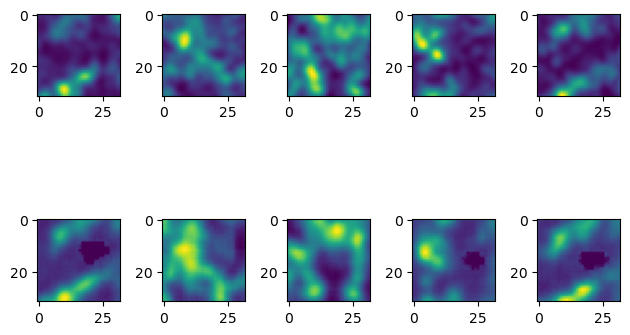

In [59]:
model.eval()

fig, ax = plt.subplots(2, 5)
ct = 0
batch = next(iter(train_loader))
x = batch['input']
y = batch['target']
pred = model(x)
for jj in range(5):
    ax[0][ct].imshow(y[jj, 0, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, ...].squeeze().detach().cpu().numpy())
    ct += 1

plt.tight_layout()
#plt.savefig('trainSet_targ_pred_fullyCAE_4input_neck100_4layer_MSE.png')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


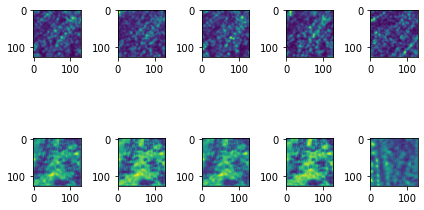

In [54]:
model_c1l2n1000.eval()
testSet = MyoDataSet('./data', 'Test', 1)
testloader = testSet.get_loader(np.arange(len(testSet)), 5, 0)

fig, ax = plt.subplots(2, 5)
ct = 0
batch = next(iter(testloader))
x = batch['input']
y = batch['target']
pred = model_c1l2n1000(x)
for jj in range(len(x)):
    ax[0][ct].imshow(y[jj, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, ...].squeeze().detach().cpu().numpy())
    ct += 1

plt.tight_layout()
plt.savefig('testSet_targ_pred_fullyCAE_4input_neck0_2layer_MSE.png')

### T-SNE of bottleneck

torch.Size([174, 1000])
torch.Size([174, 1000])


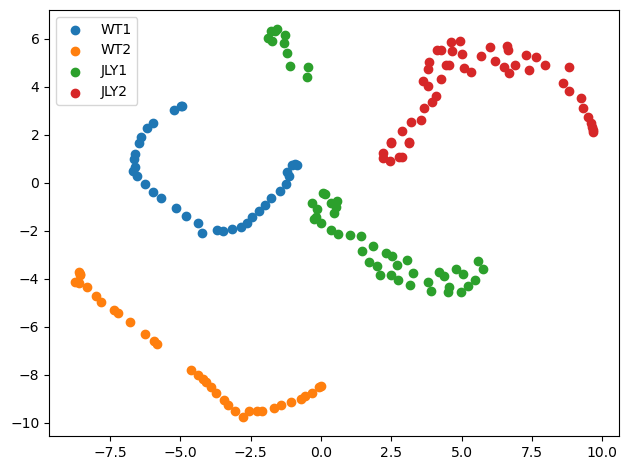

In [48]:
model.eval()
train_loader_all = trainSet.get_loader(np.arange(len(trainSet)), len(trainSet), 0)
X_in = next(iter(train_loader_all))
#print(X_in['label'])
X = model.encoding(X_in['input']).detach()
print(X.shape)
X = torch.flatten(X, start_dim = 1)
print(X.shape)
X_embedded = TSNE(n_components=2, perplexity=40, max_iter = 5000, learning_rate='auto', init='random').fit_transform(X)
#print(X_embedded.shape)
groups = ['WT1', 'WT2', 'JLY1', 'JLY2']
#print(np.where(np.array(X_in['label'])=='JLY'))
for g in groups:
    idx = np.where(np.array(X_in['label'])==g)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=g)
plt.legend()
plt.tight_layout()
plt.savefig('trainSet_tsne_fullyCAE_4input_neck100_4layer_MSE.png')
# Plot bottleneck layers
#fig, ax = plt.subplots(1, 4)
#for jj in range(len(x)):
#    ax[jj].imshow(X[jj, 3, ...].squeeze().detach().cpu().numpy())

In [47]:
help(TSNE)

Help on class TSNE in module sklearn.manifold._t_sne:

class TSNE(sklearn.base.ClassNamePrefixFeaturesOutMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', max_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
 |  
 |  T-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |

### Benchmark with Fashion MNIST

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])
mnist_trainSet = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
mnist_testSet = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

tensor(-1.)


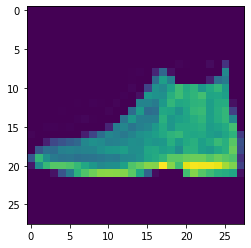

In [3]:
(img, target) = mnist_testSet[0]
plt.imshow(img.squeeze())
print(img.min())

In [6]:
sampler = SubsetRandomSampler(np.arange(len(mnist_trainSet)))
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainSet, batch_size=64, num_workers=0, sampler=SubsetRandomSampler(np.arange(1000)), pin_memory=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_testSet, batch_size=64, num_workers=0, sampler=SubsetRandomSampler(np.arange(100)), pin_memory=True)
(img, label) = next(iter(mnist_testloader))
len(mnist_trainloader)

16

In [7]:
torch.cuda.is_available()

False

In [8]:
def train(model, dataloader, lossfn, optimizer, epochNum, tb_logger, device=None):     # Training step for each epoch
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for img, target in dataloader:
        img = img.to(device)
        y = model(img)
        loss = lossfn(y, img)
        loss.backward()
        optimizer.step()
        totalLoss += loss

    if tb_logger is not None:
        tb_logger.add_scalar(tag="train_loss", scalar_value=totalLoss.item(), global_step=epochNum)

    return totalLoss/len(dataloader)

def validate(model, dataloader, lossfn, epochNum, tb_logger, device=None):      # Validate after each epoch, returns the loss 
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.eval()

    (img, label) = next(iter(dataloader))
    img = img.to(device)
    y = model(img)
    loss = lossfn(y, img)

    if tb_logger is not None:
        tb_logger.add_scalar(tag="val_loss", scalar_value=loss.item(), global_step=epochNum)

    return loss

In [26]:
input_size = (1, 28, 28)
fmap_inc_factor = 2
layers = 2
sample_factor = 2
neckdim = 100
model_test = CAE(input_size, fmap_inc_factor, layers, sample_factor, neckdim)


torch.manual_seed(0)   # Ensure reproducibility
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(params = model_test.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
#timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H:%M:%S')
logger = None#SummaryWriter('./logs/model_c1l2n1000')

numEpoch = 500
train_loss = np.zeros(numEpoch)
val_loss = np.zeros(numEpoch)
for ii in tqdm(range(numEpoch)):
    epochLoss = train(model_test, mnist_trainloader, loss, optim, ii, logger)
    validLoss = validate(model_test, mnist_testloader, loss, ii, logger)
    train_loss[ii] = epochLoss
    val_loss[ii] = validLoss
    if ii%50==1:
        print("Epoch", ii, "  Training loss:", epochLoss.detach().cpu().numpy(), ",  Validation loss:", validLoss.detach().cpu().numpy())
        scheduler.step()

#torch.save(model_3l.state_dict(), 'mixed_input_noneck_3layer_MSE.pt')


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Wen-hung\miniconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 1, 24, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (24) must match the size of tensor b (28) at non-singleton dimension 3

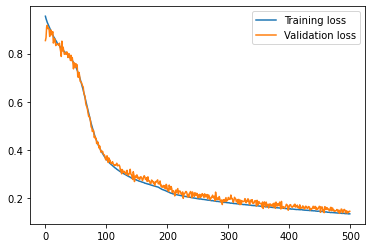

In [16]:
plt.plot(np.arange(500), train_loss, label='Training loss')
plt.plot(np.arange(500), val_loss, label='Validation loss')
plt.legend()


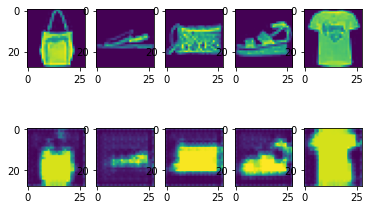

In [19]:
model_test.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img, label = next(iter(mnist_trainloader))
y = model_test(img.to(device))

fig, ax = plt.subplots(2, 5)
for ii in range(5):
    ax[0][ii].imshow(img[ii, ...].squeeze())
    ax[1][ii].imshow(y[ii, ...].detach().cpu().numpy().squeeze())

tensor([4, 3, 4, 1, 5, 0, 3, 1, 4, 7, 0, 1, 8, 5, 2, 8, 1, 6, 5, 9, 8, 6, 6, 0,
        2, 5, 5, 6, 2, 0, 8, 4, 4, 1, 7, 7, 4, 3, 9, 0, 8, 2, 5, 3, 8, 4, 7, 0,
        7, 0, 3, 5, 0, 4, 4, 7, 8, 1, 9, 3, 7, 4, 1, 9])


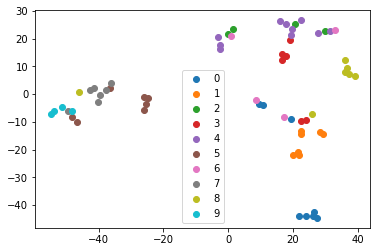

In [20]:
model_test.eval()
model_test.to(torch.device('cpu'))
X_img, X_label = next(iter(mnist_trainloader))
print(X_label)
X = model_test.encoding(X_img).detach()
X = torch.flatten(X, start_dim = 1)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
#print(X_embedded.shape)
groups = np.unique(X_label)
#print(np.where(np.array(X_in['label'])=='JLY'))
for g in groups:
    idx = np.where(np.array(X_label)==g)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=g)
plt.legend()
# Plot bottleneck layers
#fig, ax = plt.subplots(1, 4)
#for jj in range(len(x)):
#    ax[jj].imshow(X[jj, 3, ...].squeeze().detach().cpu().numpy())

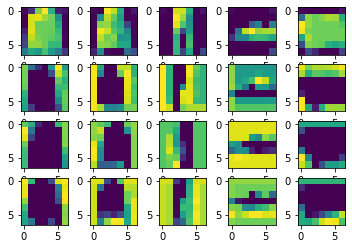

In [25]:
model_test.eval()
model_test.to(torch.device('cpu'))
X_img, X_label = next(iter(mnist_trainloader))

X = model_test.encoding(X_img).detach()
fig, ax = plt.subplots(4, 5)
for ii in range(5):
    idx = np.random.randint(len(X))
    ax[0][ii].imshow(X[idx, 0, :])
    ax[1][ii].imshow(X[idx, 1, :])
    ax[2][ii].imshow(X[idx, 2, :])
    ax[3][ii].imshow(X[idx, 3, :])